In [2]:
## input: 1. summarizedExperiement(SE) obj for chromVAR 2. Jaspar matrix 
## output: 1. motif x cell (z score) 2. plot: ranked           
source("./libs.R")

In [5]:
##------------------------------------------------------------
## inputs
##------------------------------------------------------------

input.chromVar.res.list <- readRDS(file = "../dat/output.jaspar.dev.res.Rdata")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z
input.umap.res <- fread('../dat/1908/Islet_123.MNN_corrected.cluster_labels.filt.txt',header = T)
input.chromVar.jaspar.var <- fread("../dat/1908/output.jaspar.var.res.abcd.csv")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 600 rows [5, 18, 19, 50, 81, 114, 128, 147, 169, 175, 176, 190, 209, 250, 260, 345, 353, 376, 389, 413, ...].”

barcodes                                      UMAP1    UMAP2     cluster
1 Islet3-fresh_CTGAAGCTTGCAGCTACTCTCTATTATAGCCT 6.029433 -3.429818 beta_2 
  cell_type_overall subtype log10_n_counts log10_n_peaks Islet1 Islet2 Islet3
1 beta              2       4.520863       4.152013      0      0      1

[1] 14239    11

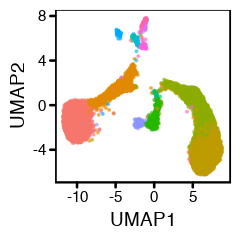

In [6]:
options(repr.plot.width = 2, repr.plot.height = 2)
# filter unkonwn
input.umap.res <- input.umap.res %>% separate(cluster, into = c("cell_type_overall", 
    "subtype"), remove = F)
head(input.umap.res, 1)
dim(input.umap.res)
ggplot(input.umap.res, aes(UMAP1, UMAP2)) + geom_point(aes(color = cluster), size = 0.1, 
    alpha = 0.5) + theme_pubr() + theme(legend.position = "none")


      alpha        beta       delta endothelial    exocrine       gamma 
       5535        7108         709         136         113         205 
      glial      immune    stellate 
         34          58         134 


      alpha        beta       delta endothelial    exocrine       gamma 
       5594        7170         718         157         131         206 
      glial      immune    stellate 
         39          71         153 

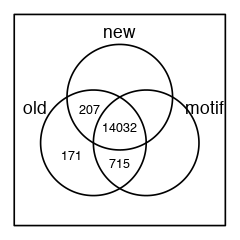

In [9]:
require(venn)
options(repr.plot.width = 2, repr.plot.height = 2)

input.umap.res.old <- fread("../dat/Islet_123.MNN_corrected.UMAP.txt")
input.chromVar.jaspar.z <- assays(input.chromVar.res.list$dev)$z

venn(list(old = input.umap.res.old$barcodes, new = input.umap.res$barcodes, motif = colnames(input.chromVar.jaspar.z)[-1]))
table(input.umap.res %>% filter(barcodes %in% colnames(input.chromVar.jaspar.z)[-1]) %>% 
    pull(cell_type_overall))
table(input.umap.res %>% pull(cell_type_overall))

In [10]:
fun.plot.project.motif <- function(motif, input.chromVar.z = input.chromVar.jaspar.z, 
    umap.res = input.umap.res, rescale = F, cls, bks = c(-4, 0, 4), ...) {
    require(scales)
    
    motif.idx <- grep(motif, rownames(input.chromVar.z))
    if (length(motif.idx) == 0) {
        message(motif, " is not found!")
        return()
    }
    
    motif.z <- input.chromVar.z[motif.idx[1], ]
    if (rescale) {
        sc <- max(abs(quantile(motif.z, probs = c(0.05, 0.95))))
        motif.z[motif.z > sc] <- sc
        motif.z[motif.z < -sc] <- -sc
    }
    
    motif.z <- motif.z %>% as.data.frame() %>% rownames_to_column("barcodes")
    colnames(motif.z)[2] <- "zval"
    
    tmp <- umap.res %>% right_join(motif.z)
    tmp <- tmp %>% mutate(zval = ifelse(zval > bks[3], bks[3], ifelse(zval < bks[1], 
        bks[1], zval)))
    p.default.cluster.motif <- ggplot(tmp, aes(UMAP1, UMAP2)) + geom_point(aes(colour = zval), 
        shape = 16, ...) + ggtitle(rownames(input.chromVar.jaspar.z)[motif.idx]) + 
        scale_color_gradientn(colours = cls, breaks = bks) + theme_pubr() + theme(text = element_blank(), 
        axis.ticks = element_blank(), legend.position = c(0.2, 0.9), legend.direction = "horizontal", 
        legend.key.width = unit(2, "mm"), legend.key.height = unit(0.1, "inches"), 
        legend.text = element_text(size = 10, family = "Arial"), legend.background = element_rect(fill = "transparent", 
            colour = "transparent"), plot.margin = unit(c(1, 1, -1, -1), "mm"))
    
    p.default.cluster.motif
}

In [12]:
table(input.umap.res%>%pull(cluster))


      alpha_1       alpha_2        beta_1        beta_2       delta_1 
         4266          1328          4354          2816           683 
      delta_2 endothelial_1 endothelial_2      exocrine         gamma 
           35            62            95           131           206 
        glial        immune      stellate 
           39            71           153 

### cell-type specific motif between beta and delta

Joining, by = "barcodes"
Joining, by = "barcodes"
Warning message:
“Removed 715 rows containing missing values (geom_point).”Warning message:
“Removed 715 rows containing missing values (geom_point).”

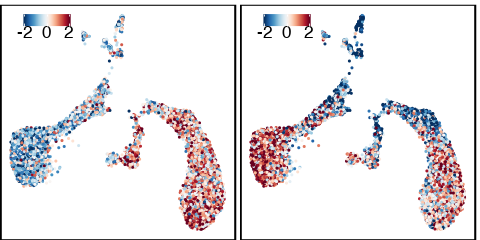

In [14]:
options(repr.plot.width = 4, repr.plot.height = 2)

ps <- lapply(c("PDX1", "FOXA1"), fun.plot.project.motif, bks = c(-2, 0, 
    2),size=.25,cls=rev(brewer.pal(n = 11, "RdBu")))
names(ps) <- c("PDX1", "FOXA1")
ggarrange(plotlist = ps, ncol = 2)

In [19]:
input.umap.res[is.na(input.umap.res)] <- 0

### T Test (one vs other) 

### T Tests (binary)

In [15]:
input.chromVar.jaspar.z <- data.table(assays(input.chromVar.res.list$dev)$z,keep.rownames = T)


# aggregate data --------------------------------------------------------------
# melt
input.chromVar.jaspar.z.agg <- melt(input.chromVar.jaspar.z, id = "rn", variable.name = "barcodes", 
    value.name = "zval")

# add celltype
input.chromVar.jaspar.z.agg <- merge(input.chromVar.jaspar.z.agg, input.umap.res) 


head(input.chromVar.jaspar.z.agg,1)
dim(input.chromVar.jaspar.z.agg)
dim(input.chromVar.jaspar.z)
table(input.chromVar.jaspar.z.agg%>%pull(cell_type_overall))

barcodes                                   rn             zval       UMAP1   
1 Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT MA0025.1_NFIL3 -0.3430543 6.975175
  UMAP2     cluster cell_type_overall subtype log10_n_counts log10_n_peaks
1 -3.232226 beta_1  beta              1       3.694693       3.384174     
  Islet1 Islet2 Islet3
1 1      0      0

[1] 5416738      13

[1]   386 14749


      alpha        beta       delta endothelial    exocrine       gamma 
    2136510     2744074      273674       52496       43618       79130 
      glial      immune    stellate 
      13124       22388       51724 

In [184]:
input.chromVar.jaspar.z.agg <- input.chromVar.jaspar.z.agg[complete.cases(input.chromVar.jaspar.z.agg), 
   ] %>% separate(rn, into = c("id", "name"), sep = "_")
range(input.chromVar.jaspar.z.agg$zval)
dim(input.chromVar.jaspar.z.agg)
head(input.chromVar.jaspar.z.agg,1)

[1] -17.90770  33.67385

[1] 5206754      14

barcodes                                   id       name  zval       UMAP1   
1 Islet1-fresh_AGACACCTAAGAGGCAAAGGAGTACCTAT MA0025.1 NFIL3 -0.3430543 6.975175
  UMAP2     cluster cell_type_overall subtype log10_n_counts log10_n_peaks
1 -3.232226 beta_1  beta              1       3.694693       3.384174     
  Islet1 Islet2 Islet3
1 1      0      0

In [157]:
table(input.chromVar.jaspar.z.agg %>% filter(name == motif)%>%pull(cell_type_overall))
table(input.chromVar.jaspar.z.agg%>%pull(cell_type_overall))


      alpha        beta       delta endothelial    exocrine       gamma 
       5535        7109         709         136         113         205 
      glial      immune    stellate 
         34          58         134 


      alpha        beta       delta endothelial    exocrine       gamma 
    2136510     2744074      273674       52496       43618       79130 
      glial      immune    stellate 
      13124       22388       51724 

In [202]:
require(parallel)
celltype.test.all <- list(alpha_vs_gamma = c("alpha", "gamma"), beta_vs_delta = c("beta", 
    "delta"))
ttest.res <- do.call(rbind, lapply(names(celltype.test.all), function(ntest) {
    # cells <- c('beta', 'delta')
    celltype.test <- celltype.test.all[[ntest]]
    test.motifs <- input.chromVar.jaspar.z.agg %>% filter(cell_type_overall %in% 
        celltype.test) %>% pull(name) %>% unique
    ttest.res <- do.call(rbind, mclapply(test.motifs, function(motif) {
        pd <- input.chromVar.jaspar.z.agg %>% filter(name == motif, cell_type_overall %in% 
            celltype.test)
        test.res <- t.test(pd %>% filter(cell_type_overall == celltype.test[1]) %>% 
            select(zval), pd %>% filter(cell_type_overall == celltype.test[2]) %>% 
            select(zval))
        (data.frame(`motif` = motif, mean_x = test.res$estimate[1], mean_y = test.res$estimate[2], 
            pval = test.res$p.value/2))
    }, mc.cores = 10)) %>% mutate(test = ntest)
}))
head(ttest.res,1)
head(ttest.res%>%filter(test=='beta_vs_delta'),1)

motif mean_x     mean_y     pval         test          
1 NFIL3 -0.2479951 0.05709858 3.703684e-05 alpha_vs_gamma

motif mean_x   mean_y    pval         test         
1 NFIL3 0.203819 0.0655054 0.0009128493 beta_vs_delta

In [333]:
ttest.res <- ttest.res %>% group_by(test) %>% mutate(FDR = p.adjust(pval, "BH"), 
    padj = p.adjust(pval, "bonferroni")) %>% rowid_to_column("rank") %>% mutate(rank = ifelse(rank > 
    386, rank - 386, rank)) %>% left_join(input.chromVar.jaspar.z.agg %>% select(name, 
    id) %>% unique, by = c(motif = "name"))

In [387]:
fwrite(ttest.res, "~/Dropbox (UCSD_Epigenomics)/workReports/2019-08-27_islet/chromVar_ttest_res.csv")

In [16]:
ttest.res<- fread("~/Dropbox (UCSD_Epigenomics)/workReports/2019-08-27_islet/chromVar_ttest_res.csv") 
dim(ttest.res)

[1] 772  13

### Motif db annotate

install.packages('data.tree')

In [48]:
head(df,1)

family.id family.name
1 0.1.1.3   Maf-related

In [95]:
df <- ttest.res.2 %>% filter(FDR < 0.01) %>% select(family.id, contains("name")) %>% 
    unique() %>% drop_na %>% mutate(name = "all", family.id = paste0("0.", family.id)) %>% 
    unite(path,name,name.y, name.x, family.name, sep = ";")
df %>% head(2)
dt.tmp <- FromDataFrameTable(df, pathName = "path", pathDelimiter = ";")
dt.tmp

                                                  levelName
1  all                                                     
2   ¦--Basic domains                                       
3   ¦   ¦--Basic leucine zipper factors (bZIP)             
4   ¦   ¦   ¦--Maf-related                                 
5   ¦   ¦   ¦--Jun-related                                 
6   ¦   ¦   ¦--Fos-related                                 
7   ¦   ¦   ¦--B-ATF-related                               
8   ¦   ¦   ¦--ATF4-related                                
9   ¦   ¦   ¦--CREB-related                                
10  ¦   ¦   °--CEBP-related                                
11  ¦   ¦--Basic helix-loop-helix factors (bHLH)           
12  ¦   ¦   ¦--Tal-related                                 
13  ¦   ¦   ¦--bHLH-ZIP                                    
14  ¦   ¦   ¦--Hairy-related                               
15  ¦   ¦   ¦--E2A                                         
16  ¦   ¦   ¦--HLH only                 

In [140]:
df <- ttest.res.2 %>% filter(FDR < 0.01) %>% select(contains("id"), contains("name")) %>% 
    unique() %>% drop_na %>% mutate(name = "all", family.id = paste0("0.", family.id))
df %>% head(1)

id       family.id class.id superclass.id family.name
1 MA0842.1 0.1.1.3   1.1      1             Maf-related
  name.x                              name.y        name
1 Basic leucine zipper factors (bZIP) Basic domains all

In [163]:
data(MisLinks)
data(MisNodes)
str(MisLinks)
str(MisNodes)

'data.frame':	254 obs. of  3 variables:
 $ source: int  1 2 3 3 4 5 6 7 8 9 ...
 $ target: int  0 0 0 2 0 0 0 0 0 0 ...
 $ value : int  1 8 10 6 1 1 1 1 2 1 ...
'data.frame':	77 obs. of  3 variables:
 $ name : Factor w/ 77 levels "Anzelma","Babet",..: 63 64 51 57 21 33 12 23 20 65 ...
 $ group: int  1 1 1 1 1 1 1 1 1 1 ...
 $ size : int  15 20 23 30 11 9 11 30 8 29 ...


In [168]:
MisNodes.2 <- rbind(df %>% select(starts_with("family")) %>% rename(id = "family.id", 
    name = "family.name"), df %>% select(class.id, name.x) %>% rename(id = "class.id", 
    name = "name.x"), df %>% select(superclass.id, name.y) %>% rename(id = "superclass.id", 
    name = "name.y"), data.frame(id = "-1", name = "all")) %>% rowid_to_column("rowid") %>% 
    mutate(id = factor(id))

MisNodes.2 %>% str
MisNodes.dic <- MisNodes.2$rowid-1
names(MisNodes.dic) <- MisNodes.2$name

'data.frame':	805 obs. of  3 variables:
 $ rowid: int  1 2 3 4 5 6 7 8 9 10 ...
 $ id   : Factor w/ 83 levels "-1","0.1.1.1",..: 4 11 11 11 11 11 2 4 11 3 ...
 $ name : Factor w/ 139 levels "AIRE","Ankyrin-only",..: 51 92 92 92 92 92 47 51 92 28 ...


In [169]:
MisLinks.2 <- ToDataFrameNetwork(dt.tmp)%>%mutate(value=1)
MisLinks.2$from = MisNodes.dic[MisLinks.2$from]
MisLinks.2$to = MisNodes.dic[MisLinks.2$to]
MisLinks.2%>%str


'data.frame':	82 obs. of  3 variables:
 $ from : num  804 804 804 804 804 804 804 536 536 536 ...
 $ to   : num  536 557 558 563 565 622 623 268 269 372 ...
 $ value: num  1 1 1 1 1 1 1 1 1 1 ...


In [170]:
# Load data
data(MisLinks)
data(MisNodes)

# Plot
forceNetwork(Links = MisLinks.2, Nodes = MisNodes.2,
            Source = "from", Target = "to",
            Value = "value", NodeID = "name",
            Group = "id", opacity = 0.8)

HTML widgets cannot be represented in plain text (need html)

In [143]:
head(ToDataFrameNetwork(dt.tmp),1)

from to           
1 all  Basic domains

In [114]:
diagonalNetwork( ToListExplicit(dt.tmp, unname = T),fontSize = 10)

HTML widgets cannot be represented in plain text (need html)

In [96]:
simpleNetwork(ToDataFrameNetwork(dt.tmp), fontSize = 6,)

HTML widgets cannot be represented in plain text (need html)

In [124]:
require(igraph)
net <- graph.data.frame(links, nodes, directed=T)

ERROR: Error in as.data.frame(d): object 'links' not found


In [122]:
install.packages(c("network",'sna'))

also installing the dependencies ‘coda’, ‘statnet.common’




The downloaded binary packages are in
	/var/folders/q6/ym1p0hfs64lg7q45qjvml83w0000gn/T//Rtmp0aVNB3/downloaded_packages


In [121]:
require(GGally)
require(network)
#require(sna)
net = rgraph(10, mode = "graph", tprob = 0.5)
net = network(net, directed = FALSE)

Loading required package: network
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘network’”

ERROR: Error in rgraph(10, mode = "graph", tprob = 0.5): could not find function "rgraph"


In [88]:
acmeNetwork

from       to                       name                    
1  Acme Inc.  Accounting               Accounting              
2  Acme Inc.  Research                 Research                
3  Acme Inc.  IT                       IT                      
4  Accounting New Software             New Software            
5  Accounting New Accounting Standards New Accounting Standards
6  Research   New Product Line         New Product Line        
7  Research   New Labs                 New Labs                
8  IT         Outsource                Outsource               
9  IT         Go agile                 Go agile                
10 IT         Switch to R              Switch to R

In [87]:
require(networkD3)
acmeNetwork <- ToDataFrameNetwork(acme, "name")
simpleNetwork(acmeNetwork[-3], fontSize = 12)

HTML widgets cannot be represented in plain text (need html)

Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'Three-zinc finger Krüppel-related' in 'mbcsToSbcs': dot substituted for <cc>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'Three-zinc finger Krüppel-related' in 'mbcsToSbcs': dot substituted for <88>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“font metrics unknown for Unicode character U+0308”

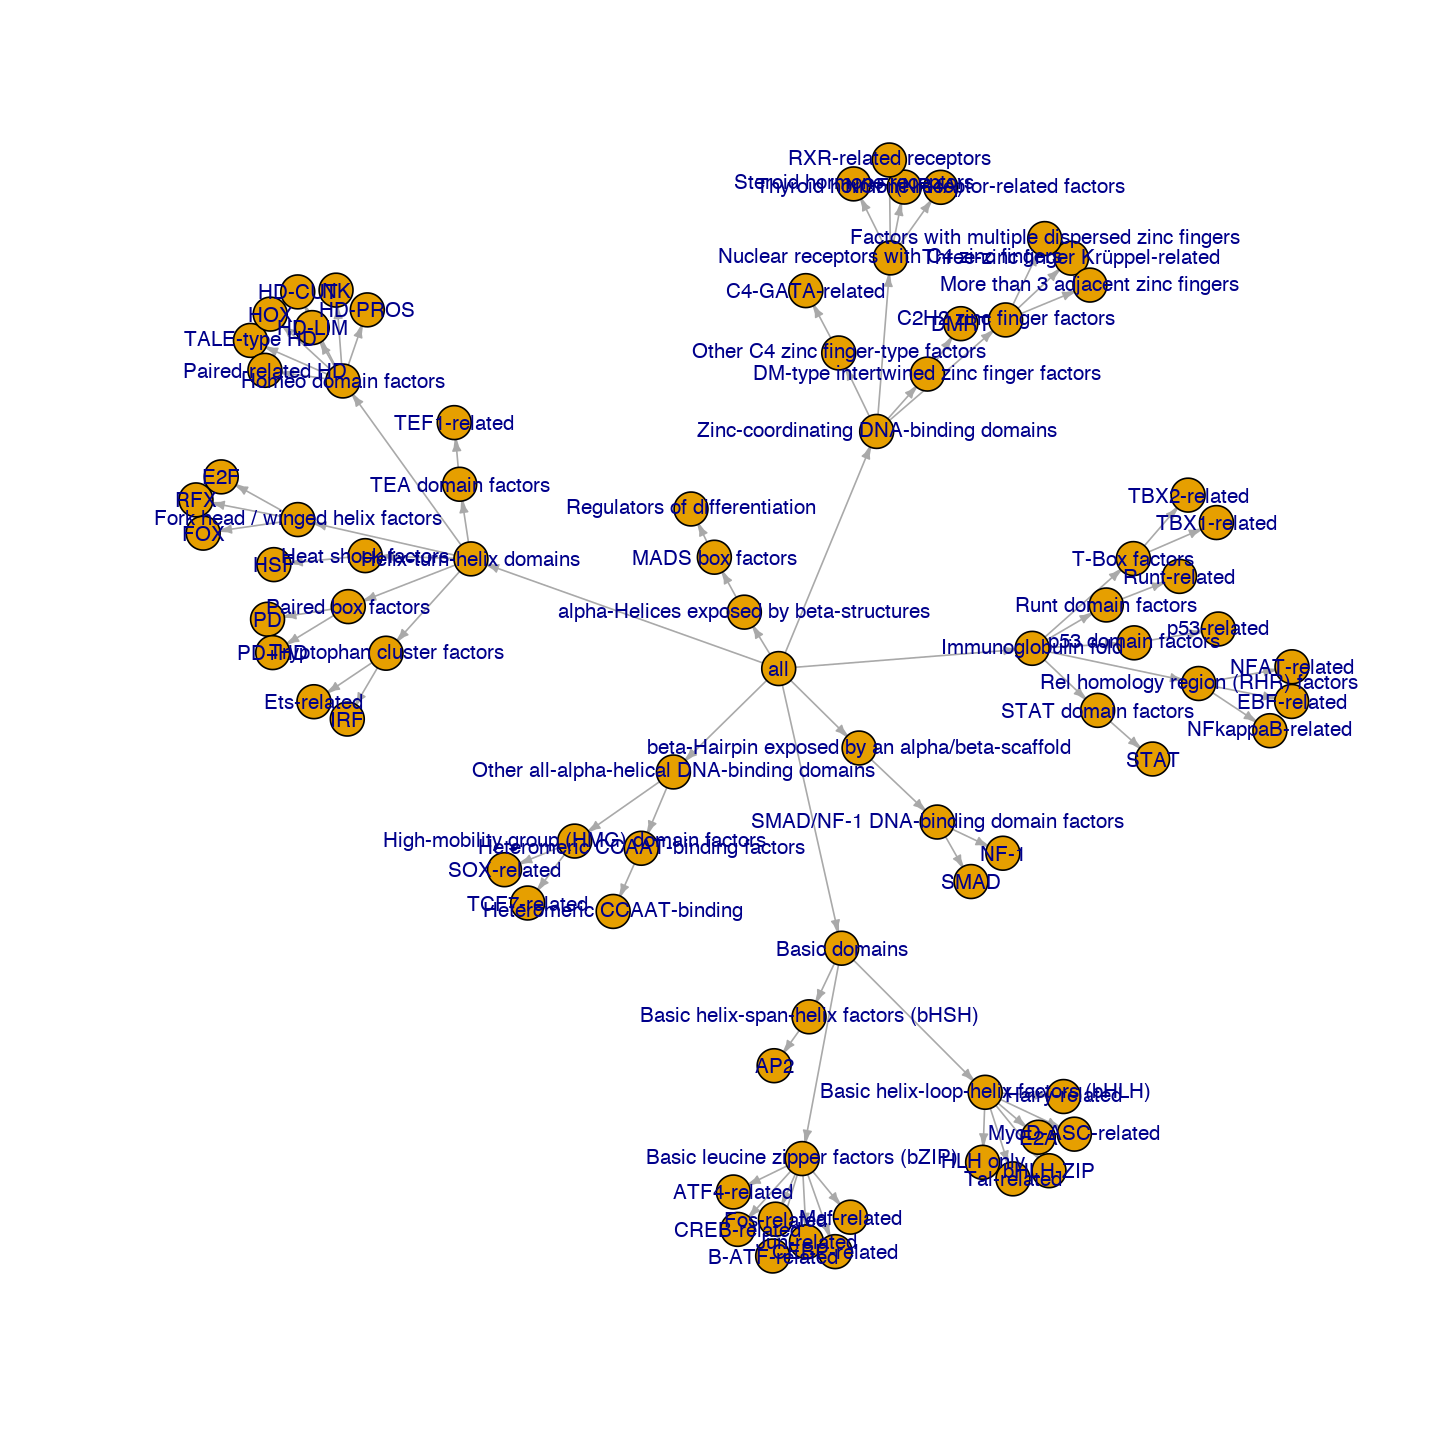

In [136]:
options(repr.plot.width = 12, repr.plot.height = 12)

dt.tmp.ig <- as.igraph(dt.tmp, directed = TRUE, direction = "climb")
#net <- simplify(dt.tmp.ig, remove.multiple = F, remove.loops = T)
plot(dt.tmp.ig,vertex.size=6,edge.arrow.size=.25)

Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'Three-zinc finger Krüppel-related' in 'mbcsToSbcs': dot substituted for <cc>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'Three-zinc finger Krüppel-related' in 'mbcsToSbcs': dot substituted for <88>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“font metrics unknown for Unicode character U+0308”

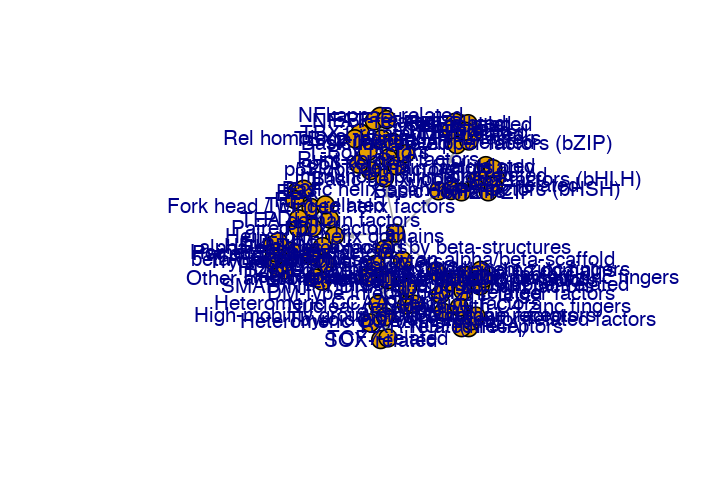

In [116]:
require(igraph)
plot(as.igraph(dt.tmp, directed = TRUE, direction = "climb"),cex=.5)


In [82]:
SetGraphStyle(dt.tmp,rankdir='TB')
plot(dt.tmp)

HTML widgets cannot be represented in plain text (need html)

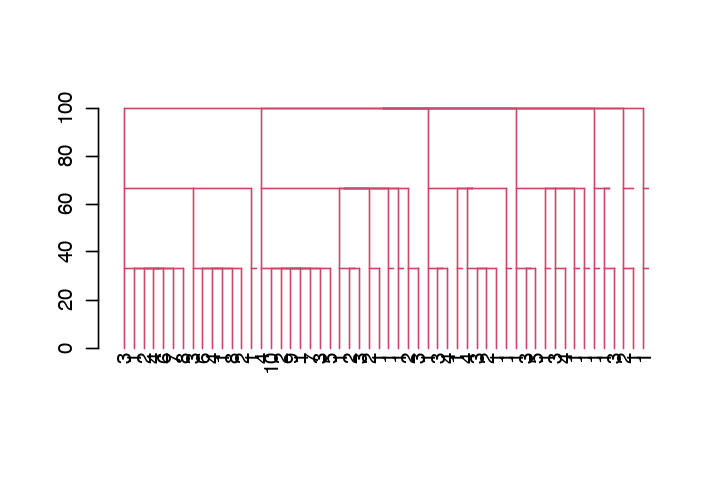

In [42]:
require(dendextend)
dt.tmp %>% as.dendrogram%>%set('branches_k_color',k=1)%>%plot

In [22]:
dim(ttest.res)
ttest.res.2 <- (ttest.res %>% left_join(tfclass.db.dic$merged %>% select(jaspar.id, family.id, 
    family.name), by = c(id = "jaspar.id"))%>%unique())


[1] 772  13

In [55]:
head(tfclass.db$class,1)

id name           
1 0  Uncharacterized
  about                                                                                                                                                          
1 Class description: No DNA-binding domain has been identified in these factors, although there is evidence that they may be (DNA-binding) transcription factors.

In [61]:
ttest.res.2<- ttest.res.2 %>% mutate(class.id = sub(".[[:digit:]]$", "", family.id)) %>% 
    left_join(tfclass.db$class%>%select(-about), by = c("class.id" = "id"))%>%
    mutate(superclass.id = sub(".[[:digit:]]$", "", class.id)) %>% 
    left_join(tfclass.db$superclass%>%select(-about), by = c("superclass.id" = "id"))

In [514]:
tmp.dup <- ttest.res.2 %>% group_by(test) %>% filter(duplicated(motif))
#ttest.res.2 %>% filter(motif %in% tmp.dup$motif)

In [400]:
sum(!ttest.res$id %in% tfclass.db.dic$jasparTOtfclass$jaspar.id)
sum(!ttest.res$id %in% tfclass.db.dic$merged$jaspar.id)
remain.motif <- ttest.res[!ttest.res$id %in% tfclass.db.dic$merged$jaspar.id,c('motif','id')]%>%unique
sum(remain.motif$motif %in% tfclass.db.dic$merged$genus.name)
remain.motif[!(remain.motif$motif %in% tfclass.db.dic$merged$genus.name),]

[1] 50

[1] 34

[1] 14

motif    id      
1 FOS::JUN MA0099.2
2 NFYA     MA0060.2
3 NFIC     MA0161.1

In [17]:
tfclass.db.dic <- readRDS("~/github/atacMotif/db/dic_jaspar_tfclass.rds")
str(tfclass.db.dic)

List of 4
 $ jasparTOensembl : Named chr [1:579] "ENSG00000130700" "ENSG00000107485" "ENSG00000179348" "ENSG00000141448" ...
  ..- attr(*, "names")= chr [1:579] "MA0766.1" "MA0037.3" "MA0036.3" "MA1104.1" ...
 $ ensemblTOtfclass:'data.frame':	5502 obs. of  8 variables:
  ..$ genus.id      : chr [1:5502] "3.1.8.1.1" "3.1.8.1.1" "3.1.8.1.2" "3.1.8.1.2" ...
  ..$ genus.name    : chr [1:5502] "ADNP1" "ADNP1" "ADNP2" "ADNP2" ...
  ..$ tf.symbol     : Factor w/ 1475 levels "A-MYB","ADNP1",..: 2 2 3 3 4 4 5 5 6 6 ...
  ..$ subfamily.id  : chr [1:5502] "3.1.8.1" "3.1.8.1" "3.1.8.1" "3.1.8.1" ...
  ..$ subfamily.name: chr [1:5502] "ADNP" "ADNP" "ADNP" "ADNP" ...
  ..$ subfamily.seq : chr [1:5502] "" "" "" "" ...
  ..$ family.id     : chr [1:5502] "3.1.8" "3.1.8" "3.1.8" "3.1.8" ...
  ..$ family.name   : Factor w/ 109 levels "AIRE","Ankyrin-only",..: 40 40 40 40 67 67 70 70 70 70 ...
 $ jasparTOtfclass :'data.frame':	620 obs. of  10 variables:
  ..$ jaspar.id     : chr [1:620] "MA0854.1" "MA0634

In [57]:
tfclass.db <- readRDS('~/github/atacMotif/db/tfclass.rds')
str(tfclass.db)

List of 7
 $ subfamily :'data.frame':	337 obs. of  3 variables:
  ..$ id  : chr [1:337] "1.1.1.1" "1.1.1.2" "1.1.1.3" "1.1.2.1" ...
  ..$ name: chr [1:337] "Jun" "NFE2" "ATF2" "Fos" ...
  ..$ seq : chr [1:337] "TGAGTCA" "GCTGAGTCA" "TGACGTCA" "TGAGTCA" ...
 $ family    :'data.frame':	110 obs. of  2 variables:
  ..$ id  : chr [1:110] "0.0.1" "0.0.2" "0.0.3" "0.0.4" ...
  ..$ name: chr [1:110] "NULP1" "PHF5" "RFXANK" "RFXAP" ...
 $ genus     :'data.frame':	1453 obs. of  2 variables:
  ..$ id  : chr [1:1453] "3.5.1.1.2" "3.1.8.1.1" "3.1.8.1.2" "2.3.2.4.9" ...
  ..$ name: chr [1:1453] "A-Myb (MYBL1)" "ADNP1" "ADNP2" "AEBP2" ...
 $ genus.dup :'data.frame':	4 obs. of  2 variables:
  ..$ id  : chr [1:4] "3.5.1.3.4" "3.5.1.3.5" "3.5.1.3.6" "3.5.1.3.7"
  ..$ name: chr [1:4] "MTA1" "MTA2" "MTA3" "RERE"
 $ merge     :'data.frame':	1475 obs. of  9 variables:
  ..$ genus.id      : chr [1:1475] "3.1.8.1.1" "3.1.8.1.2" "2.3.2.4.9" "1.2.5.1.1" ...
  ..$ genus.name    : chr [1:1475] "ADNP1" "ADNP2" "AE

In [360]:
rm(input.pseudotime)

### plots - ranked bars

In [2]:
#require(devtools)
#install_github("jokergoo/ComplexHeatmap")
require(ComplexHeatmap)

In [331]:
ttest.res <- ttest.res %>% mutate(padj.1 = ifelse(enriched %in% c("gamma", "delta"), 
    -FDR, FDR))%>%arrange(enriched,padj.1)%>%select(-padj.1)

In [301]:
ttest.res <- ttest.res %>% mutate(diff = mean_x - mean_y) %>% arrange(test, diff) 

In [17]:
require(circlize)

rank motif mean_x      mean_y    pval     test           x     y     enriched
1 191  ELF5  -0.03122941 0.9949915 9.07e-21 alpha_vs_gamma alpha gamma gamma   
  FDR          padj       
1 2.059424e-19 3.50102e-18

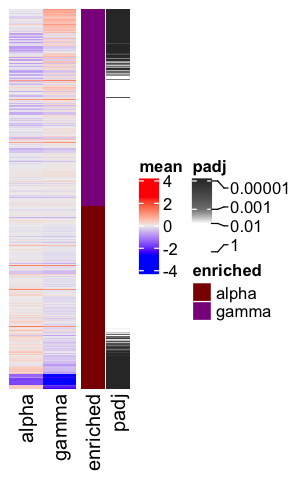

In [296]:
options(repr.plot.width = 2.5, repr.plot.height = 4)

ttest.res %>% head(1)
pd.rank <- ttest.res %>% filter(test == "alpha_vs_gamma") %>% ungroup
# pd.rank <- ttest.res %>% filter(test == 'beta_vs_delta')
require(ComplexHeatmap)
pvalue_col_fun = colorRamp2(c(0, 2, 3, 5), c("white", "grey100", "grey50", "grey20"))
ha = rowAnnotation(enriched = anno_simple(pd.rank %>% pull(enriched), col = c(alpha = "darkred", 
    gamma = "magenta4")), padj = anno_simple(-log10(pd.rank %>% pull(padj)), col = pvalue_col_fun))
ht = Heatmap(pd.rank %>% select(starts_with("mean")) %>% rename(alpha = mean_x, gamma = mean_y) %>% 
    as.matrix(), right_annotation = ha, cluster_rows = F, name = "mean", cluster_columns = F)
lgd_pvalue = Legend(title = "padj", col = pvalue_col_fun, at = c(0, 2, 3, 5), labels = c("1", 
    "0.01", "0.001", "0.00001"))
lgd_enriched = Legend(title = "enriched", legend_gp = gpar(fill = c("darkred", "magenta4")), 
    labels = c("alpha", "gamma"))

draw(ht, annotation_legend_list = list(lgd_pvalue, lgd_enriched))

rank motif mean_x      mean_y    pval     test           x     y     enriched
1 191  ELF5  -0.03122941 0.9949915 9.07e-21 alpha_vs_gamma alpha gamma gamma   
  FDR          padj        diff     
1 2.059424e-19 3.50102e-18 -1.026221

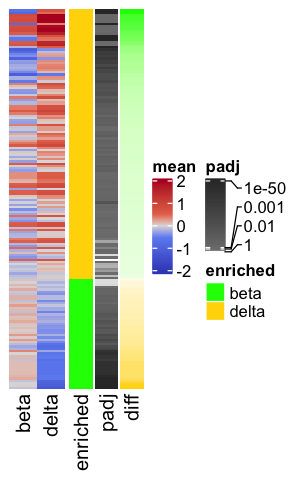

In [310]:
options(repr.plot.width = 2.5, repr.plot.height = 4)

ttest.res %>% head(1)
# pd.rank <- ttest.res %>% filter(test == 'alpha_vs_gamma') %>% ungroup
pd.rank <- ttest.res %>% filter(test == "beta_vs_delta") %>% ungroup %>% filter(padj < 
    0.01)
require(ComplexHeatmap)
pvalue_col_fun = colorRamp2(c(0, 2, 3, 50), c("white", "grey100", "grey50", "grey20"))
cls <- coolwarm(7)

main_col_fun = colorRamp2(c(-2, -0.5, 0, 0.5, 2), cls[c(1:2, 4, 6:7)])
ha = rowAnnotation(enriched = anno_simple(pd.rank %>% pull(enriched), col = c(beta = "green", 
    delta = "gold")), padj = anno_simple(-log10(pd.rank %>% pull(padj)), col = pvalue_col_fun), 
    diff = anno_simple(pd.rank$diff, col = colorRamp2(c(-1.3, 0, 1.1), c("green", 
        "white", "gold"))))
ht = Heatmap(col = main_col_fun, pd.rank %>% select(starts_with("mean")) %>% rename(beta = mean_x, 
    delta = mean_y) %>% as.matrix(), right_annotation = ha, cluster_rows = F, name = "mean", 
    cluster_columns = F)
lgd_pvalue = Legend(title = "padj", col = pvalue_col_fun, at = c(0, 2, 3, 50), labels = c("1", 
    "0.01", "0.001", "1e-50"))
lgd_enriched = Legend(title = "enriched", legend_gp = gpar(fill = c("green", "gold")), 
    labels = c("beta", "delta"))

draw(ht, annotation_legend_list = list(lgd_pvalue, lgd_enriched))

In [353]:
pd.rank%>%head(20)%>%mutate(rank=motif.1)%>%select(rank,motif)

rank motif
1   1   NRL  
2   2   MAFF 
3   3   MAFK 
4   4   MAFG 
5   5   FOXP2
6   6   FOXG1
7   7   FOXP1
8   8   FOXI1
9   9   FOXL1
10 10   FOXD2
11 11   FOXO4
12 12   FOXO6
13 13   FOXP3
14 14   NFIC 
15 15   FOXD1
16 16   FOXO3
17 17   FOXC2
18 18   FOXC1
19 19   GLIS3
20 20   NFIA

rank motif mean_x      mean_y    pval     test          x    y     enriched
1 187  NRL   -0.09615801 -1.187419 2.32e-89 beta_vs_delta beta delta beta    
  FDR        padj       diff    
1 8.9552e-87 8.9552e-87 1.091261

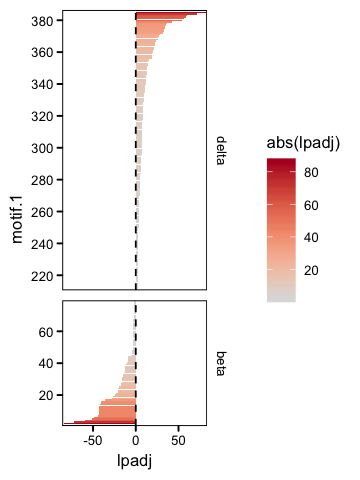

In [350]:
options(repr.plot.width = 3, repr.plot.height = 4)
require(pals) 

pd.rank <- ttest.res %>% filter(test == "beta_vs_delta") %>% ungroup

head(pd.rank, 1)
n_m =nrow(pd.rank %>% filter(enriched == 'delta'))
n_m =0
pd.rank <- pd.rank %>% mutate(motif.1 = as.numeric(factor(motif, levels = pd.rank$motif))-n_m, 
    lpadj = ifelse(enriched == "beta", log10(FDR), -log10(FDR))) %>% filter(FDR < 
    0.01) %>% mutate(enriched = factor(enriched, levels = c("delta", "beta")))
ggplot(pd.rank) + geom_bar(aes(motif.1, lpadj, fill = abs(lpadj)), stat = "identity") + 
    theme_pubr(base_size = 10) + theme() + coord_flip(expand = F) + scale_fill_gradientn(colours = pal.compress(coolwarm)[7:13]) + 
    scale_x_continuous(breaks = seq(0-n_m, 386-n_m, 20)) + facet_grid(enriched ~ ., scales = "free_y", 
    space = "free_y")+geom_hline(yintercept = 0,linetype=2)
# geom_vline(xintercept =  %>%
# pull(rank))) +
ggsave("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.b_d.rank.pdf",
    width = 3, height = 4, units = "in")

In [349]:
pd.rank%>%head(10)

rank motif   mean_x    mean_y     pval     test           x     y    
1   1   MAFG    0.4259281 -2.0168799 1.42e-74 alpha_vs_gamma alpha gamma
2   2   MAFF    0.3068051 -2.2408924 4.83e-70 alpha_vs_gamma alpha gamma
3   3   NRL     0.4858033 -1.7127294 4.15e-68 alpha_vs_gamma alpha gamma
4   4   MAFK    0.3117224 -2.0511534 4.98e-66 alpha_vs_gamma alpha gamma
5   5   NEUROD2 0.4342266 -0.6098203 5.11e-32 alpha_vs_gamma alpha gamma
6   6   NR2F1   0.1864563 -0.7663685 2.89e-29 alpha_vs_gamma alpha gamma
7   7   BHLHE22 0.4391133 -0.5001222 1.81e-27 alpha_vs_gamma alpha gamma
8   8   OLIG1   0.4253420 -0.4702521 3.73e-26 alpha_vs_gamma alpha gamma
9   9   BHLHE23 0.4503831 -0.4162862 1.46e-24 alpha_vs_gamma alpha gamma
10 10   OLIG2   0.3858121 -0.4520210 2.21e-24 alpha_vs_gamma alpha gamma
   enriched FDR          padj        diff      motif.1 lpadj    
1  alpha    5.481200e-72 5.48120e-72 2.4428080  1      -71.26112
2  alpha    9.321900e-68 1.86438e-67 2.5476975  2      -66.72947
3  alpha    5.339667e-66 1.60190e-65 2.1985327  3      -64.79536
4  alpha    4.805700e-64 1.92228e-63 2.3628758  4      -62.71618
5  alpha    3.944920e-30 1.97246e-29 1.0440470  5      -28.70499
6  alpha    1.859233e-27 1.11554e-26 0.9528248  6      -25.95251
7  alpha    9.980857e-26 6.98660e-25 0.9392356  7      -24.15573
8  alpha    1.799725e-24 1.43978e-23 0.8955941  8      -22.84170
9  alpha    6.261778e-23 5.63560e-22 0.8666693  9      -21.24906
10 alpha    8.281455e-23 8.53060e-22 0.8378331 10      -21.06902

rank motif mean_x    mean_y   pval     test           x     y     enriched
1 1    MAFG  0.4259281 -2.01688 1.42e-74 alpha_vs_gamma alpha gamma alpha   
  FDR        padj       diff    
1 5.4812e-72 5.4812e-72 2.442808

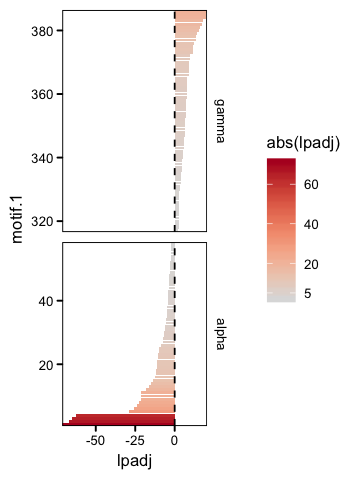

In [347]:
options(repr.plot.width = 3, repr.plot.height = 4)
require(pals)

pd.rank <- ttest.res %>% filter(test == "alpha_vs_gamma") %>% ungroup

head(pd.rank, 1)
n_m = nrow(pd.rank %>% filter(enriched == "gamma"))
n_m = 0
pd.rank <- pd.rank %>% mutate(motif.1 = as.numeric(factor(motif, levels = pd.rank$motif)) - 
    n_m, lpadj = ifelse(enriched == "alpha", log10(padj), -log10(padj))) %>% filter(padj < 
    0.01) %>% mutate(enriched = factor(enriched, levels = c("gamma", "alpha")))
ggplot(pd.rank) + geom_bar(aes(motif.1, lpadj, fill = abs(lpadj)), stat = "identity") + 
    theme_pubr(base_size = 10) + theme() + coord_flip(expand = F) + scale_fill_gradientn(colours = pal.compress(coolwarm)[7:13], 
    breaks = c(0, 2, 5, 20, 40, 60, 80)) + scale_x_continuous(breaks = seq(0 - 
    n_m, 386 - n_m, 20)) + facet_grid(enriched ~ ., scales = "free_y", space = "free_y") + 
    geom_hline(yintercept = 0, linetype = 2)
# geom_vline(xintercept = %>% pull(rank))) +
ggsave("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.a_g.rank.pdf", 
    width = 3, height = 4, units = "in")

### plots


In [223]:
cols.subtypes=c(alpha1='darkred',alpha2='lightpink',
               beta1='darkgreen',beta2='lightgreen',
               gamma1='orange',gamma2='gold')

In [237]:
cols.celltype["beta"] = rgb(t((col2rgb(cols.celltype["beta_1"]) + col2rgb(cols.celltype["beta_2"]))/2), 
    maxColorValue = 255)
cols.celltype["alpha"] = rgb(t((col2rgb(cols.celltype["alpha_1"]) + col2rgb(cols.celltype["alpha_2"]))/2), 
    maxColorValue = 255)
cols.celltype["delta"] = rgb(t((col2rgb(cols.celltype["delta_1"]) + col2rgb(cols.celltype["delta_2"]))/2), 
    maxColorValue = 255)

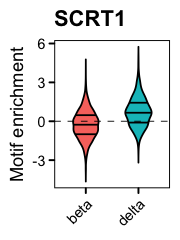

In [185]:
options(repr.plot.width = 3, repr.plot.height = 2)

m <- "NFIL3"
celltype.test <- c("alpha", "gamma")
plotViolin <- function(motif = m, test_celltypes = celltype.test) {
    pd <- input.chromVar.jaspar.z.agg %>% filter(name == motif, cell_type_overall %in% 
        test_celltypes)
    ggviolin(pd, x = "cell_type_overall", remove = T, width = 0.5, y = "zval", size = 0.5, 
        shape = 16, draw_quantiles = c(0.25, 0.5, 0.75), fill = "cell_type_overall", 
        ylab = "Motif enrichment") + theme_pubr() + ggtitle(motif) + geom_hline(yintercept = 0, 
        linetype = 2, size = 0.25) + theme(legend.position = "none", axis.text.x = element_text(angle = 45, 
        hjust = 1), axis.title.x = element_blank())
    
}


options(repr.plot.width = 1.5, repr.plot.height = 2)

plotViolin("SCRT1", c("beta", "delta"))

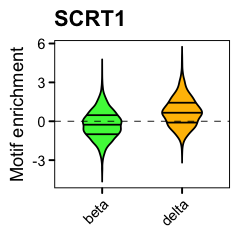

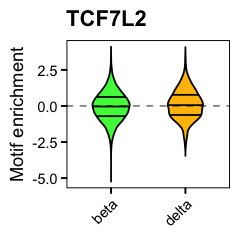

In [346]:
plotViolin("SCRT1", c("beta", "delta")) + scale_fill_manual(values = c(beta = cols.celltype$beta, 
    delta = cols.celltype$delta))
plotViolin("TCF7L2", c("beta", "delta")) + scale_fill_manual(values = c(beta = cols.celltype$beta, 
    delta = cols.celltype$delta))

In [253]:
ttest.res%>%filter(motif %in% c("TCF7L2"))

rank motif  mean_x      mean_y     pval        test           x     y    
1  85  TCF7L2 -0.03064506 0.09302175 8.07058e-04 beta_vs_delta  beta  delta
2 204  TCF7L2 -0.01133480 0.48557587 1.91000e-12 alpha_vs_gamma alpha gamma
  enriched FDR          padj        
1 delta    1.469455e-03 3.115244e-01
2 gamma    1.714558e-11 7.372600e-10

In [145]:
options(repr.plot.width = 4, repr.plot.height = 4)
p1<- plotMotif(m="MAFG", "alpha_vs_gamma",size=1,bks=c(-3,0,3))
p2<-plotMotif(m="MEIS1", "alpha_vs_gamma",size=1,bks=c(-3,0,3))
#plotMotif(m="ELF5", "alpha_vs_gamma",size=1,bks=c(-2,0,2))
plotMotif(m="EHF", "alpha_vs_gamma",size=1,bks=c(-2,0,2))

ERROR: Error in plotMotif(m = "MAFG", "alpha_vs_gamma", size = 1, bks = c(-3, : could not find function "plotMotif"


Joining, by = "barcodes"


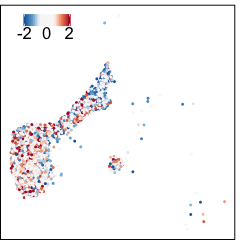

In [356]:
options(repr.plot.width = 2, repr.plot.height = 2)

plotMotif(m="FOXP2", "alpha_vs_gamma",size=.5, cls = rev(vals),bks=c(-2,0,2))

Joining, by = "barcodes"


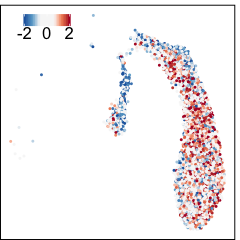

In [355]:
options(repr.plot.width = 2, repr.plot.height = 2)

plotMotif(m="FOXP2", "beta_vs_delta",size=.5, cls = rev(vals),bks=c(-2,0,2))

Joining, by = "barcodes"


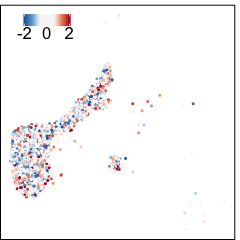

In [345]:

plotMotif(m="TCF7L2", "alpha_vs_gamma",size=.5, cls = rev(vals),bks=c(-2,0,2))

Joining, by = "barcodes"


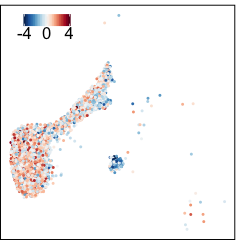

In [159]:
options(repr.plot.width = 2, repr.plot.height = 2)
plotMotif <- function(m = "SCRT1", cmp = "alpha_vs_gamma",...) {
    
    p <- fun.plot.project.motif(motif = m,...)
    p %+% (p$data %>% filter(cell_type_overall %in% unlist(strsplit(cmp, split = "_vs_"))))
    
}
plotMotif(m="MAFK", "alpha_vs_gamma",size=.5)

In [339]:
pd.rank%>%filter(grepl('TCF',motif))

rank motif  mean_x      mean_y      pval        test          x    y    
1 105  CTCF   -0.43046074 -0.29270361 0.004158581 beta_vs_delta beta delta
2  85  TCF7L2 -0.03064506  0.09302175 0.000807058 beta_vs_delta beta delta
3  78  TCF3    0.01189289  0.16372772 0.000492461 beta_vs_delta beta delta
  enriched FDR          padj      diff       motif.1 lpadj   
1 delta    0.0065787388 1.0000000 -0.1377571 219     2.181857
2 delta    0.0014694547 0.3115244 -0.1236668 239     2.832844
3 delta    0.0009364037 0.1900899 -0.1518348 246     3.028537

Joining, by = "barcodes"


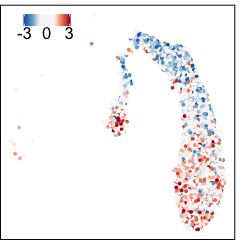

In [340]:
options(repr.plot.width = 2, repr.plot.height = 2)

p <- plotMotif("TCF3", "beta_vs_delta", size = 0.75, bks = c(-3, 0, 3), cls = rev(vals))
p

Joining, by = "barcodes"
Joining, by = "barcodes"


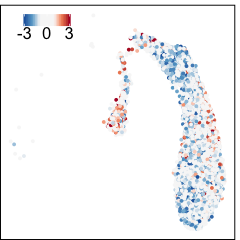

Joining, by = "barcodes"


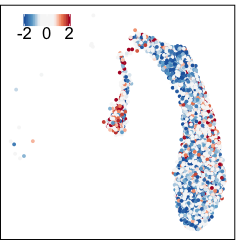

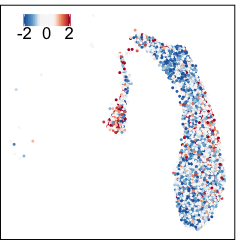

In [329]:
vals <- brewer_pal(palette = "RdBu")(7)
vals[3:5] <- vals[4]
options(repr.plot.width = 2, repr.plot.height = 2)

p <- plotMotif("EHF", "beta_vs_delta", size = 0.75, bks = c(-3, 0, 3), cls = rev(vals))
p
p <- plotMotif("EHF", "beta_vs_delta", size = 0.75, bks = c(-2, 0, 2), cls = rev(vals))
p
p <- plotMotif("EHF", "beta_vs_delta", size = 0.5, bks = c(-2, 0, 2), cls = rev(vals))
p

Joining, by = "barcodes"


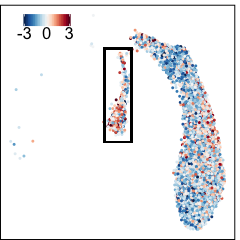

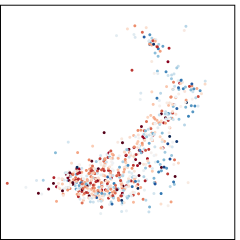

In [255]:
options(repr.plot.width = 2, repr.plot.height = 2)

p <- plotMotif("EHF", "beta_vs_delta", size = 0.5, bks = c(-3, 0, 3))
xxmin = -1.3
xxmax = 1
yymin = -2.5
yymax = 1.5
p + geom_rect(xmin = xxmin, xmax = xxmax, ymin = yymin, ymax = yymax, fill = NA, 
    color = "black")
ggsave("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.ehf.b_d.umap.pdf", 
    width = 2, height = 2, units = "in")
p$data <- p$data %>% filter(cell_type_overall == "delta")
p + coord_cartesian(ylim = c(yymin, yymax), xlim = c(xxmin, xxmax)) + theme(legend.position = "none")
ggsave("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.ehf.b_d.umap.insert.pdf", 
    width = 1, height = 1, units = "in")

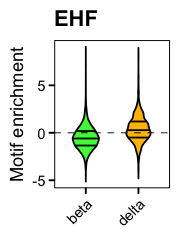

In [247]:
options(repr.plot.width = 1.5, repr.plot.height = 2)
plotViolin("EHF", c("beta", "delta")) + scale_fill_manual(values = c(beta = cols.celltype$beta, 
    delta = cols.celltype$delta))
ggsave("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.ehf.b_d.umap.insert.violin.pdf", 
    width = 1.5, height = 2, units = "in")

Joining, by = "barcodes"


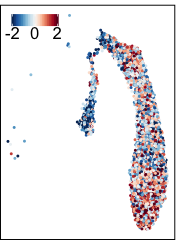

In [250]:
plotMotif("MAFF", "beta_vs_delta", size = 0.5, bks = c(-2, 0, 2))
ggsave("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.maff.b_d.umap.pdf", 
    width = 2, height = 2, units = "in",useDingbats=F)


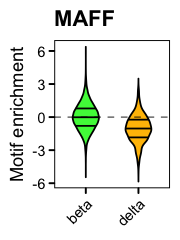

In [249]:
options(repr.plot.width = 1.5, repr.plot.height = 2)
plotViolin("MAFF", c("beta", "delta")) + scale_fill_manual(values = c(beta = cols.celltype$beta, 
    delta = cols.celltype$delta))
ggsave("~/Dropbox (UCSD_Epigenomics)/workReports/2019-09_islet_rev/Fig.1.maff.b_d.umap.insert.violin.pdf", 
    width = 1.5, height = 2, units = "in")

Joining, by = "barcodes"


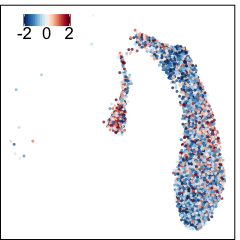

Joining, by = "barcodes"


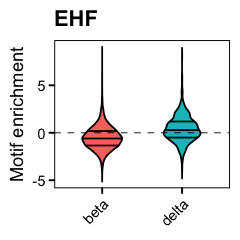

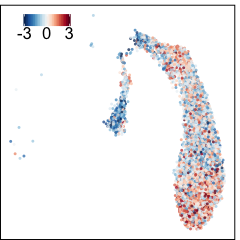

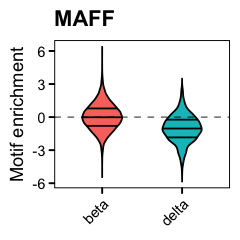

In [208]:
#options(repr.plot.width = 6, repr.plot.height = 6)

p<- plotMotif("EHF", "beta_vs_delta",size=.5,bks=c(-2,0,2),alpha=.75)
p
plotViolin("EHF", c("beta", "delta"))

plotMotif("MAFF", "beta_vs_delta",size=.5,bks=c(-3,0,3),alpha=.75)
plotViolin("MAFF", c("beta", "delta"))

Joining, by = "barcodes"


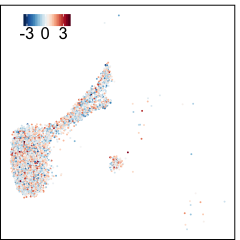

In [341]:
options(repr.plot.width = 2, repr.plot.height = 2)

plotMotif("EGR", "alpha_vs_gamma")

Joining, by = "barcodes"


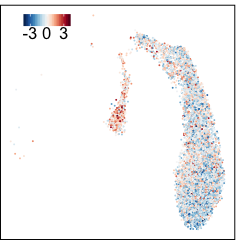

In [339]:
options(repr.plot.width = 2, repr.plot.height = 2)

plotMotif("EHF", "beta_vs_delta")

In [334]:
options(repr.plot.width = 5, repr.plot.height = 4, max_z = 3)
plotSNmotif <- function(testt = "alpha_vs_gamma", fdr_th = 0.001) {
    top_motifs <- ttest.res %>% filter(padj < fdr_th & test == testt) %>% pull(motif)
    
    cell_types <- unlist(strsplit(testt, "_vs_"))
    pd <- input.chromVar.jaspar.z.agg %>% filter(name %in% top_motifs & cell_type_overall %in% 
        cell_types) %>% select(barcodes, name, zval, cell_type_overall) %>% mutate(motif = as.numeric(factor(name, 
        levels = top_motifs)))
    dim(pd)
    pd$zval[pd$zval > max_z] <- max_z
    pd$zval[pd$zval < -max_z] <- -max_z
    
    tmp <- pd %>% select(barcodes, cell_type_overall) %>% unique() %>% arrange(cell_type_overall)
    # dim(tmp %>% mutate(barcodes))
    
    pd <- pd %>% mutate(barcodes = as.numeric(factor(barcodes, levels = tmp$barcodes)))
    
    print(seps <- table(tmp %>% unique() %>% pull(cell_type_overall)))
    
    print(seps.motif <- table(ttest.res %>% filter(padj < fdr_th & test == testt) %>% 
        pull(enriched)))
    
    ncolor = 5
    ggplot(pd, aes(x = barcodes, y = motif)) + geom_raster(aes(fill = zval)) + geom_hline(yintercept = as.numeric(cumsum(seps.motif))[1], 
        linetype = 2, size = 0.5) + geom_vline(xintercept = as.numeric(cumsum(seps))[1], 
        linetype = 2, size = 0.5) + coord_cartesian(expand = F) + theme_bw() + theme(panel.grid = element_blank()) + 
        scale_fill_gradientn(colors = colorRampPalette(c("blue", "white", "red"))(ncolor), 
            breaks = seq(-3, 3, length.out = ncolor))
}


alpha gamma 
 5535   205 

alpha gamma 
   58    70 


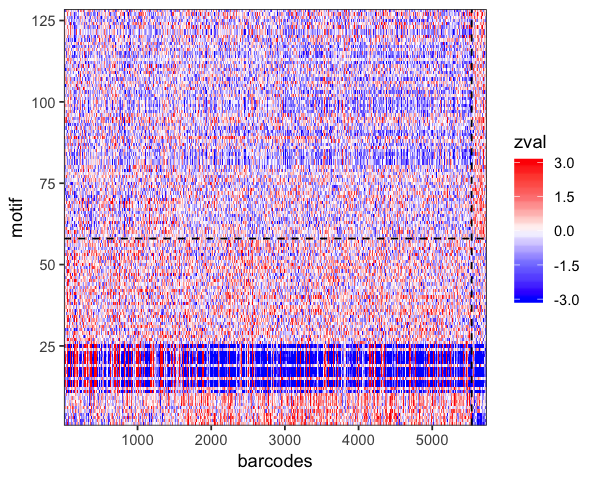

In [337]:
plotSNmotif(testt = 'alpha_vs_gamma',fdr_th = .01)

In [377]:
p <- plotSNmotif(testt = "alpha_vs_gamma", fdr_th = 0.01)



alpha gamma 
 5535   205 

alpha gamma 
   58    70 


In [400]:
quantileNorm <- function(dat.vect,lowq = 0.05) {
    dat <- as.numeric(dat.vect)
    lowq = 0.05
    (qs <- as.numeric(quantile(dat, c(lowq, 1 - lowq))))
    dat <- (dat - qs[1])/(qs[2] - qs[1])
    dat[dat > 1] <- 1
    dat[dat < 0] <- 0
    dat
}


In [424]:
require(pals)


 beta delta 
 7109   709 

 beta delta 
   45   108 


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


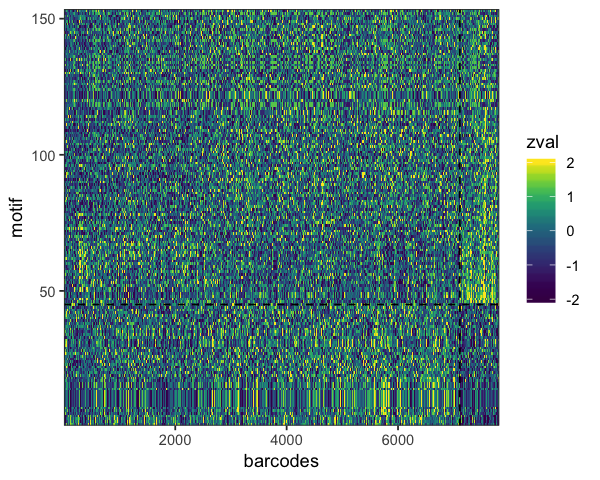

In [441]:
p <- plotSNmotif(testt = "beta_vs_delta", fdr_th = 0.001)
p$data <- p$data %>% group_by(motif) %>% mutate(zval = scale(zval, center = T))
p$data$zval[p$data$zval > 2] <- 2
p$data$zval[p$data$zval < -2] <- -2
print(p + scale_fill_gradientn(colours = colorRampPalette((viridis(30)), bias = .75)(30)))


alpha gamma 
 5535   205 

alpha gamma 
   58    70 


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


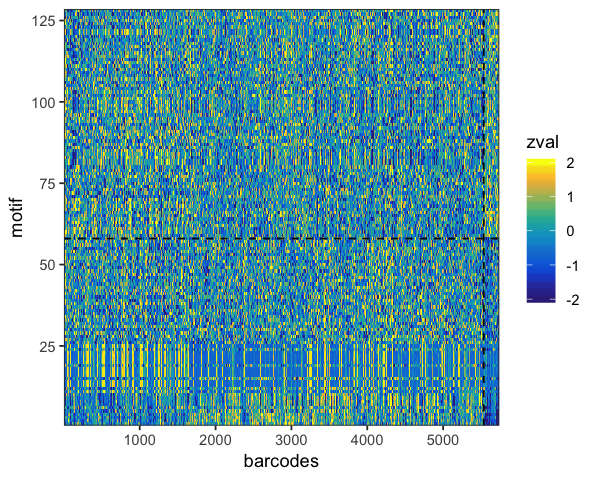

In [429]:
p <- plotSNmotif(testt = "alpha_vs_gamma", fdr_th = 0.01)
p$data <- p$data %>% group_by(motif) %>% mutate(zval = scale(zval, center = T))
p$data$zval[p$data$zval > 2] <- 2
p$data$zval[p$data$zval < -2] <- -2
print(p + scale_fill_gradientn(colours = colorRampPalette(parula(30),bias=.75)(30)))


alpha gamma 
 5535   205 

alpha gamma 
   58    70 


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


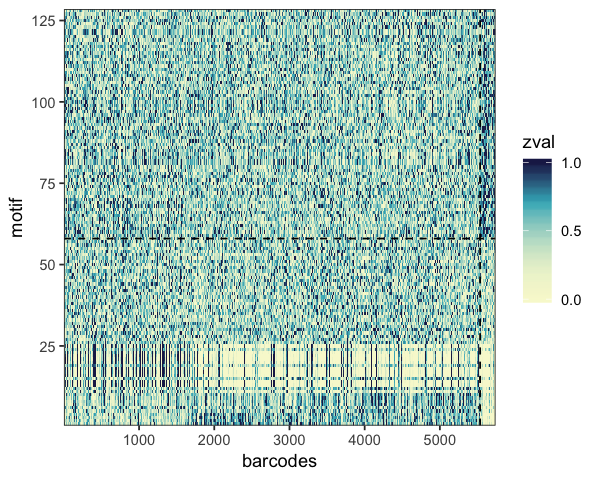

In [406]:
options(repr.plot.width = 5, repr.plot.height = 4)
p <- plotSNmotif(testt = "alpha_vs_gamma", fdr_th = 0.01)
p$data <- p$data %>% group_by(motif) %>% mutate(zval = quantileNorm(dat.vect = zval))
print(p + scale_fill_gradientn(colours = colorRampPalette(cols.hm.avg.tf(30), bias = 0.5)(30), 
    breaks = seq(0, 1, length.out = 3)))


alpha gamma 
 5535   205 

alpha gamma 
   58    70 


barcodes name zval      cell_type_overall motif
1 1        EHF  0.9106399 alpha             67

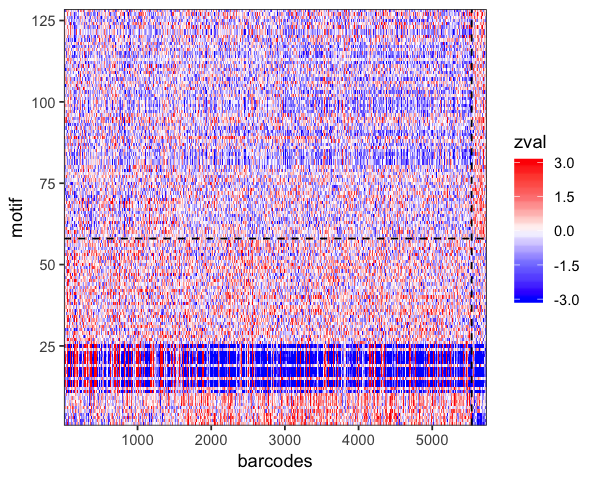

In [348]:
options(repr.plot.width = 5, repr.plot.height = 4, max_z = 3)
p<- plotSNmotif(testt = 'alpha_vs_gamma',fdr_th = .01)
print(p)



 beta delta 
 7109   709 

 beta delta 
   45   108 


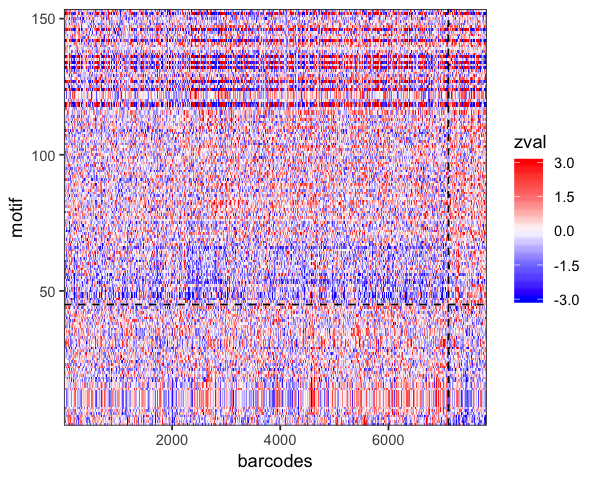

In [335]:
plotSNmotif(testt = 'beta_vs_delta')